In [2]:
from skimage import color, io, measure, img_as_ubyte, util, data, morphology
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, matrix_transform, SimilarityTransform, EuclideanTransform, warp, swirl
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.decomposition import PCA
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, label2rgb
from skimage.filters import threshold_otsu, prewitt_h, prewitt_v, prewitt
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening
from skimage.segmentation import clear_border
from scipy.stats import norm
from scipy.spatial import distance
import scipy.io as sio
import glob
import os
import SimpleITK as sitk
from IPython.display import clear_output


### 1

In [25]:
x = np.loadtxt("Images/pistachio_data.txt", comments="%")
mn = np.mean(x, axis=0)

data = x-mn
standard_deviations = np.std(data, axis=0)
standardized_data = data / standard_deviations

covariance_matrix = np.cov(standardized_data, rowvar=False)

# Find the maximum absolute value in the covariance matrix
max_absolute_value = np.max(np.abs(covariance_matrix))
max_absolute_value

1.0050251256281415

In [29]:
# Perform PCA on the standardized data
pca = PCA()
pca.fit(standardized_data)

# Project the first nut (first row of standardized data) onto the principal components
projection = pca.transform(standardized_data[0].reshape(1, -1))

# Compute the sum of squared projected values for the first nut
sum_of_squares = np.sum(projection**2)
sum_of_squares

19.595333191942174

In [30]:
# Find the index of the measurement with the smallest standard deviation
smallest_std_index = np.argmin(standard_deviations)

# Get the name of the measurement corresponding to the index
measurement_with_smallest_std = f"Measurement {smallest_std_index + 1}"

measurement_with_smallest_std

'Measurement 5'

In [36]:
# Calculate the cumulative variance explained by the principal components
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to explain at least 97% of the variance
n_components_97 = np.argmax(cumulative_variance >= 0.97) + 1  # Adding 1 because indices start from 0
n_components_97

4

In [55]:
# Load the image as an RGB image
image = io.imread('Images/ardeche_river.jpg')

def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = color.rgb2gray(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.2
    max_desired = 0.8
    img_out = ((max_desired- min_desired)/(max_val - min_val))*(img_float-min_val) + min_desired
    # Do something here

    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return (img_out)

image_stretch =histogram_stretch(image)
average_value = np.mean(image_stretch)

print("Average value of the histogram-stretched image:", average_value)


Average value of the histogram-stretched image: 0.4763035761289877


In [58]:

# Extract edges using the Prewitt horizontal filter
edges = prewitt_h(image_stretch)

# Compute the maximum absolute value of the Prewitt filtered image
max_abs_value = np.max(np.abs(edges))

print("Maximum absolute value of the Prewitt filtered image:", max_abs_value)

Maximum absolute value of the Prewitt filtered image: 0.5348138823529411


In [59]:
binary_image = image_stretch > average_value

# Compute the number of foreground pixels in the binary image
foreground_pixels = np.sum(binary_image)

print("Number of foreground pixels in the binary image:", foreground_pixels)

Number of foreground pixels in the binary image: 244957


In [63]:
image_files = ['Images/Fish/discus.jpg', 'Images/Fish/guppy.jpg', 'Images/Fish/kribensis.jpg', 'Images/Fish/neon.jpg', 'Images/Fish/oscar.jpg',
               'Images/Fish/platy.jpg', 'Images/Fish/rummy.jpg', 'Images/Fish/scalare.jpg', 'Images/Fish/tiger.jpg', 'Images/Fish/zebra.jpg']
images = [img_as_float(io.imread(filename)) for filename in image_files]

average_image = np.mean(images, axis=0)
image_flattened = [image.ravel() for image in images]
image_matrix = np.array(image_flattened)

# Perform PCA
pca = PCA(n_components=6)
principal_components = pca.fit_transform(image_matrix)

# Load the specific images for neon and guppy
neon_image = img_as_float(io.imread('Images/Fish/neon.jpg'))
guppy_image = img_as_float(io.imread('Images/Fish/guppy.jpg'))

# Compute sum of squared differences
ssd = np.sum((neon_image - guppy_image) ** 2)

print(f'Sum of squared differences between neon and guppy: {ssd}')

Sum of squared differences between neon and guppy: 62528.665928489034


In [64]:
# from scipy.spatial.distance import euclidean
# Find the index for the neon fish
neon_index = image_files.index('Images/Fish/neon.jpg')

# Extract the PCA coordinates for the neon fish
neon_pca_coords = principal_components[neon_index]

# Calculate the Euclidean distance from the neon fish to all other fish in PCA space
distances = np.array([distance.euclidean(neon_pca_coords, pca_coords) for pca_coords in principal_components])

# Find the index of the fish farthest away from the neon fish
farthest_index = np.argmax(distances)

# Output the type of fish that is the furthest away
print(f"The fish furthest away from the neon fish in PCA space is: {image_files[farthest_index]}")

The fish furthest away from the neon fish in PCA space is: Images/Fish/platy.jpg


In [65]:
# Get the explained variance ratio for each component
variance_ratios = pca.explained_variance_ratio_

# Calculate the total variance explained by the first two components
total_variance_explained = variance_ratios[0] + variance_ratios[1]

print(f"Total variance explained by the first two components: {total_variance_explained * 100:.2f}%")

Total variance explained by the first two components: 45.92%


In [66]:
3*1.4/2

2.0999999999999996

In [68]:
# Load the moving image
img1_path = 'Images/ImgT1_v1.nii'  # Update this path
img2_path = 'Images/ImgT1_v2.nii'  # Update this path
sitk_img2 = sitk.ReadImage(img2_path, sitk.sitkFloat32)
sitk_img1 = sitk.ReadImage(img1_path, sitk.sitkFloat32)

# Create the transformation (roll)
rotation_angle = -20  # Roll by -20 degrees
rotation_axis = (1, 0, 0)  # Roll around the x-axis

# Define the center of rotation as the geometric center of the image
image_center = sitk_img2.TransformIndexToPhysicalPoint([size // 2 for size in sitk_img2.GetSize()])

# Create the rotation transform
transform = sitk.Euler3DTransform()
transform.SetCenter(image_center)
transform.SetRotation(np.deg2rad(rotation_angle), 0, 0)  # Only apply roll

# Resample the image with the rotation applied
resampled_img2 = sitk.Resample(sitk_img2, sitk_img2, transform, sitk.sitkLinear, 0.0, sitk_img2.GetPixelID())

In [71]:
# Create a brain mask from ImgT1_v1 where voxel intensity > 50
threshold = 50
mask_img1 = sitk_img1 > threshold

# Create a brain mask from ImgT1_v1 where voxel intensity > 50
threshold = 50
mask_img1 = sitk_img1 > threshold

# Convert mask to binary for use in calculations
mask_array = sitk.GetArrayFromImage(mask_img1).astype(np.bool_)

# Get numpy arrays from the SimpleITK images
img1_array = sitk.GetArrayFromImage(sitk_img1)
img2_transformed_array = sitk.GetArrayFromImage(resampled_img2)

# Compute the Mean Squared Error within the mask
mse = np.mean((img1_array[mask_array] - img2_transformed_array[mask_array]) ** 2)

print(f"The mean squared error (MSE) within the brain mask is: {mse}")



The mean squared error (MSE) within the brain mask is: 43745.5078125


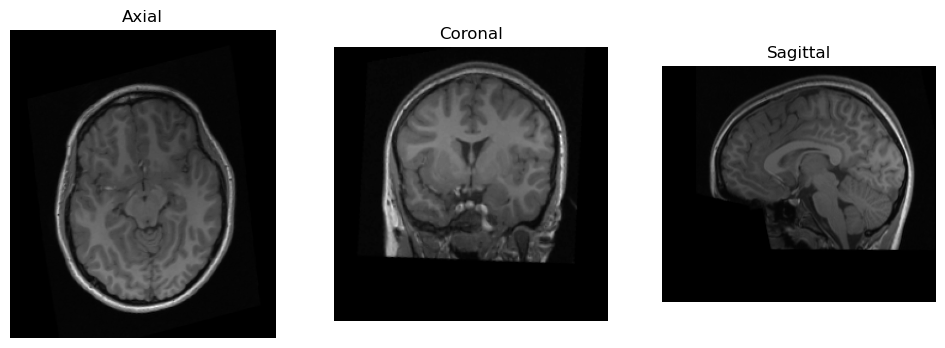

In [73]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

# Define the affine transformation
A = np.array([[0.98, -0.16, 0.17, 0],
              [0.26, 0.97, 0, -15],
              [-0.17, 0.04, 0.98, 0],
              [0, 0, 0, 1]])

# Convert numpy array to SimpleITK transform
affine_transform = sitk.AffineTransform(3)
affine_transform.SetMatrix(A[:-1,:-1].flatten())
affine_transform.SetTranslation([A[0,3], A[1,3], A[2,3]])

# Define the center of rotation as the geometric center of the image
image_center = sitk_img2.TransformIndexToPhysicalPoint([size // 2 for size in sitk_img2.GetSize()])
affine_transform.SetCenter(image_center)

# Resample the image with the transformation
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(sitk_img2)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetTransform(affine_transform)
transformed_img2 = resampler.Execute(sitk_img2)

# Show the transformed image in orthogonal views
imshow_orthogonal_view(transformed_img2, origin=None)

In [74]:
def registration(fixed_image_path, moving_image_path):
    # Load images
    fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
    moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)

    # Initial alignment of the moving image
    initial_transform = sitk.CenteredTransformInitializer(fixed_image,
                                                          moving_image,
                                                          sitk.Euler3DTransform(),
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)

    # Set up the registration framework
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    # Interpolator
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100,
                                                      convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Set the initial and moving transform
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Execute the registration
    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32),
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))

    # Extract transformation parameters
    final_params = final_transform.GetParameters()
    rotation_degrees = np.rad2deg(final_params[:3])  # Convert radians to degrees
    translation_mm = final_params[3:]  # Translation in millimeters

    return rotation_degrees, translation_mm

# Paths to the images
fixed_image_path = 'Images/ImgT1_v1.nii'  # Update path
moving_image_path = 'Images/ImgT1_v2.nii'  # Update path

# Perform the registration
rotation, translation = registration(fixed_image_path, moving_image_path)

print("Estimated rotation (degrees):", rotation)
print("Estimated translation (mm):", translation)

Estimated rotation (degrees): [ 0.121104   10.27198726  0.1083949 ]
Estimated translation (mm): (7.864246456964942, 6.65018401790141, 29.407188965665014)


In [78]:
# Load the images
frame_1 = io.imread('Images/frame_1.jpg')
frame_2 = io.imread('Images/frame_2.jpg')

# Convert images to HSV
hsv_1 = rgb2hsv(frame_1)
hsv_2 = rgb2hsv(frame_2)

# Extract and scale the Saturation (S) channel
s_1 = hsv_1[:, :, 1] * 255
s_2 = hsv_2[:, :, 1] * 255

# Compute the absolute difference between the two S images
difference_image = np.abs(s_1 - s_2)

# Compute the average value and the standard deviation
average_value = np.mean(difference_image)
std_deviation = np.std(difference_image)
# Compute the threshold as the average value plus two times the standard deviation
threshold = average_value + 2 * std_deviation

# Convert the difference image into a binary image using the threshold
binary_image = difference_image > threshold
# Count the number of pixels that are considered changed (foreground)
number_of_changed_pixels = np.sum(binary_image)
# Label the connected components (BLOBs)
labeled_image = measure.label(binary_image)

# Perform region properties analysis
regions = measure.regionprops(labeled_image)

# Find the largest BLOB by area
if regions:
    largest_blob_area = max(region.area for region in regions)
else:
    largest_blob_area = 0

print("Largest BLOB area in pixels:", largest_blob_area)
print("Average Value of the Difference Image:", average_value)
print("Standard Deviation of the Difference Image:", std_deviation)
print("Threshold used for binarization:", threshold)
print("Number of changed pixels:", number_of_changed_pixels)
print("Threshold used for binarization:", threshold)

Largest BLOB area in pixels: 10290.0
Average Value of the Difference Image: 22.96914720640888
Standard Deviation of the Difference Image: 30.098936580087404
Threshold used for binarization: 83.16702036658369
Number of changed pixels: 24820
Threshold used for binarization: 83.16702036658369


In [95]:
# Load the DICOM file
dicom_path = 'Images/HeartCT/1-001.dcm'
dicom_data = dicom.read_file(dicom_path)
dicom_pixels = dicom_data.pixel_array
print(dicom_pixels.shape)
print(dicom_pixels.dtype)
# Load ROI masks (replace 'path_to/' with the actual paths)
myocardium_roi = io.imread('Images/HeartCT/MyocardiumROI.png')
blood_roi = io.imread('Images/HeartCT/bloodROI.png')
blood_gt = io.imread('Images/HeartCT/bloodGT.png')

(512, 512)
int16


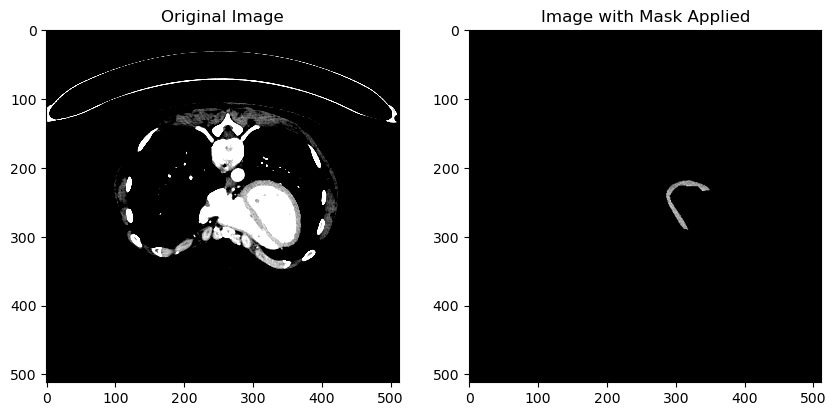

In [96]:
# Apply the ROI masks
myocardium_pixels = dicom_pixels[myocardium_roi > 0 ]
blood_pixels = dicom_pixels[blood_roi > 0]
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(dicom_pixels,  vmin=0, vmax=150, cmap='gray')
plt.title('Original Image')

# Create an image to show the mask applied: use np.zeros_like to create a blank image with the same dimensions as the original
masked_image = np.zeros_like(dicom_pixels)
masked_image[myocardium_roi > 0] = myocardium_pixels  # Apply only spleen values to the masked image

plt.subplot(1, 2, 2)
plt.imshow(masked_image, cmap='gray')
plt.title('Image with Mask Applied')

plt.show()
# Calculate mean and standard deviation for the blood ROI
mu = np.mean(blood_pixels)
sigma = np.std(blood_pixels)

In [97]:
# Define the threshold range
lower_bound = mu - 3 * sigma
upper_bound = mu + 3 * sigma

# Create the binary image
binary_image = np.logical_and(dicom_pixels > lower_bound, dicom_pixels < upper_bound).astype(int)

# Morphological operations
closing_selem = morphology.disk(3)
opening_selem = morphology.disk(5)
binary_closed = morphology.binary_closing(binary_image, footprint=closing_selem)
binary_opened = morphology.binary_opening(binary_closed, footprint=opening_selem)
# Label connected components
label_image = measure.label(binary_opened)
properties = measure.regionprops(label_image)

# Filter regions by area
filtered_regions = [prop for prop in properties if 2000 < prop.area < 5000]

# Display the areas of the remaining BLOBs
print("Areas of BLOBs after filtering:", [prop.area for prop in filtered_regions])

blood_gt = io.imread('Images/HeartCT/bloodGT.png')

# Create a binary image from filtered regions
auto_segmentation = np.zeros_like(blood_gt)
for region in filtered_regions:
    for coord in region.coords:
        auto_segmentation[coord[0], coord[1]] = 1

# Assuming bloodGT.png is binary where foreground (blood) is 1
dice_score = 2 * np.sum(auto_segmentation[blood_gt == 1]) / (np.sum(auto_segmentation) + np.sum(blood_gt))
print("DICE Score:", dice_score)


Areas of BLOBs after filtering: [3246.0]
DICE Score: 0.9375729288214703


In [98]:
# Compute mean values for myocardium and blood pixels
myocardium_mean = np.mean(myocardium_pixels)
blood_mean = np.mean(blood_pixels)

# Compute the class limit as the average of the two means
class_limit = (myocardium_mean + blood_mean) / 2
print("Class Limit between Myocardium and Blood:", class_limit)

Class Limit between Myocardium and Blood: 178.41210536488592


In [99]:
# Assuming 'binary_opened' is the binary image after morphological operations
# Label the connected components (BLOBs)
labeled_image = measure.label(binary_opened)

# Measure properties of labeled regions
regions = measure.regionprops(labeled_image)

# Count of BLOBs before filtering
total_blobs = len(regions)
print("Total number of BLOBs before filtering:", total_blobs)

Total number of BLOBs before filtering: 5


In [100]:
# Compute the mean and standard deviation
mu = np.mean(blood_pixels)
sigma = np.std(blood_pixels)

# Compute class limits
lower_limit = mu - 3 * sigma
upper_limit = mu + 3 * sigma

print("Class range in Hounsfield units:")
print("Lower Limit:", lower_limit)
print("Upper Limit:", upper_limit)

Class range in Hounsfield units:
Lower Limit: 209.98726921194577
Upper Limit: 295.58624588055665


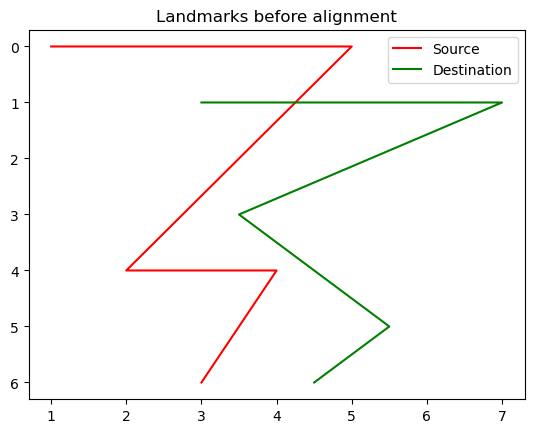

In [109]:
src = np.array([[1,0], [5,0], [2,4], [4,4], [3,6]])
dst = np.array([[3,1], [7,1], [3.5, 3], [5.5, 5], [4.5, 6]])

fig, ax = plt.subplots()
ax.plot(src[:, 0], src[:, 1], '-r', markersize=12, label="Source")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks before alignment")
plt.show()

In [117]:
# Calculate the centroids (mean positions) of each set of landmarks
centroid_standing = np.mean(src, axis=0)
centroid_running = np.mean(dst, axis=0)

# Compute the optimal translation by finding the difference between centroids
optimal_translation = centroid_standing - centroid_running

print("Optimal Translation ΔX, ΔY:", optimal_translation)

# Estimate the similarity transform
tform = SimilarityTransform()
tform.estimate(src, dst)

# Retrieve the rotation component of the transform
rotation_radians = tform.rotation
rotation_degrees = math.degrees(rotation_radians)

# Print the absolute value of the rotation in degrees
print("Absolute rotation in degrees:", abs(rotation_degrees))


# Calculate the differences between each pair of corresponding points
differences = src - dst

# Square the differences
squared_differences = differences**2

# Sum the squared differences for each point and then sum across all points
ssd = np.sum(squared_differences)

print("Sum-of-Squared-Distances (SSD) before any transformation:", ssd)

e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f = error_x + error_y
print(f"Landmark alignment error F: {f}")

Optimal Translation ΔX, ΔY: [-1.7 -0.4]
Absolute rotation in degrees: 8.226722464108176
Sum-of-Squared-Distances (SSD) before any transformation: 18.75
Landmark alignment error F: 18.75
